In [1]:
pip install scikit_learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [93]:
import numpy as np
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import pandas as pd

In [94]:
Data = pd.read_csv("P300CrossTesting_K_Protocol(Sheet1).csv")
Data = Data.to_numpy()
Acc_Matrix = Data[0:,5:]
dims = Acc_Matrix.shape
Acc_Matrix = Acc_Matrix.astype(float)

# Transforming the accuracy matrix into something more distance
ep = 0.00001
Distance_Matrix = (1 - (Acc_Matrix / 100.0)) * 100

Symetrized_Mat = (Distance_Matrix + Distance_Matrix.T)/2

np.fill_diagonal(Symetrized_Mat, 0)

preProcessScale = MinMaxScaler()
ScaledDist = preProcessScale.fit_transform(Symetrized_Mat)

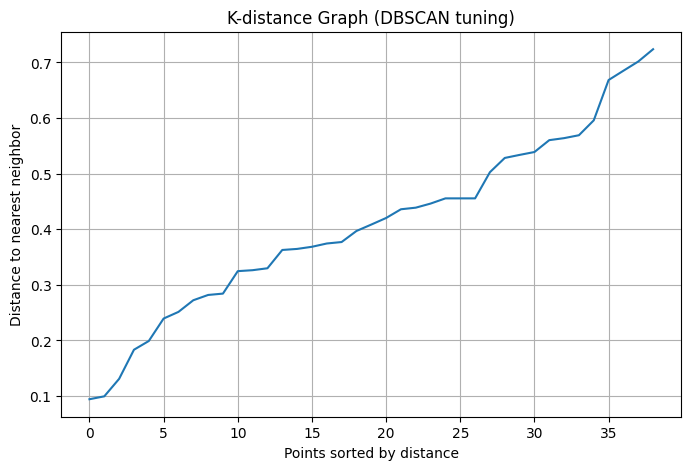

In [7]:
neigh = NearestNeighbors(n_neighbors=2,metric= 'precomputed')
neighFit = neigh.fit(ScaledDist)
distances, indices = neighFit.kneighbors(ScaledDist)
distances = np.sort(distances[:, 1])
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title('K-distance Graph (DBSCAN tuning)')
plt.ylabel('Distance to nearest neighbor')
plt.xlabel('Points sorted by distance')
plt.grid(True)
plt.show()

In [8]:
dbscan = DBSCAN(eps=0.45, min_samples=5,metric = 'precomputed')
dbscan.fit(ScaledDist)
labels = dbscan.labels_

print("Cluster assignments:", labels)

Cluster assignments: [-1 -1  0  0 -1 -1  0 -1  0 -1 -1 -1  0 -1 -1  0 -1  0  0  0  0  0 -1  0
  0  0 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  0 -1 -1]


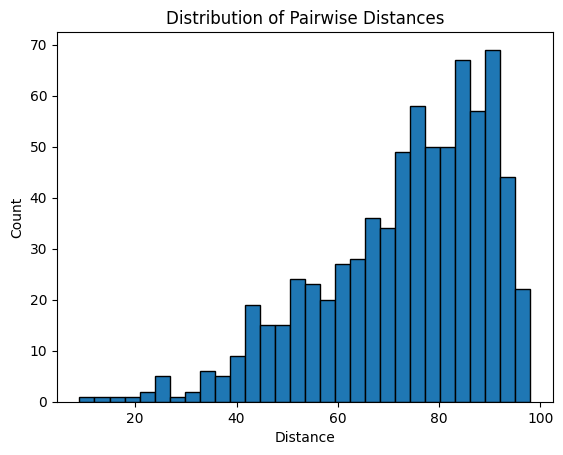

In [9]:
dists = Symetrized_Mat[np.triu_indices_from(Symetrized_Mat, k=1)]

plt.hist(dists, bins=30, edgecolor='black')
plt.title("Distribution of Pairwise Distances")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show()

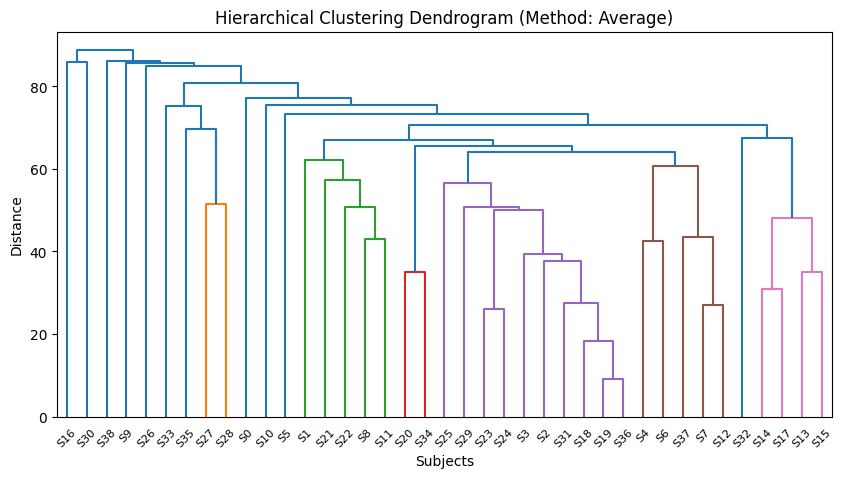

In [11]:
condensed = squareform(Symetrized_Mat)
linksAv = linkage(condensed, method ='average')

plt.figure(figsize=(10,5))
dendrogram(linksAv, labels=[f"S{i}" for i in range(Symetrized_Mat.shape[0])])
plt.title("Hierarchical Clustering Dendrogram (Method: Average)")
plt.xlabel("Subjects")
plt.ylabel("Distance")
plt.show()

In [92]:
labelsAv = fcluster(linksAv, t = 0, criterion='distance')
groupsAv = list(set(labels))
print("Unique Groups:",groups)
print("Cluster labels:", labels)

Unique Groups: [1, 2, 3, 4, 5, 6, 7]
Cluster labels: [1 2 2 2 5 2 5 5 2 7 1 2 5 3 3 3 7 3 2 4 2 2 2 1 1 4 4 6 6 4 7 4 3 5 2 6 4
 5 6]


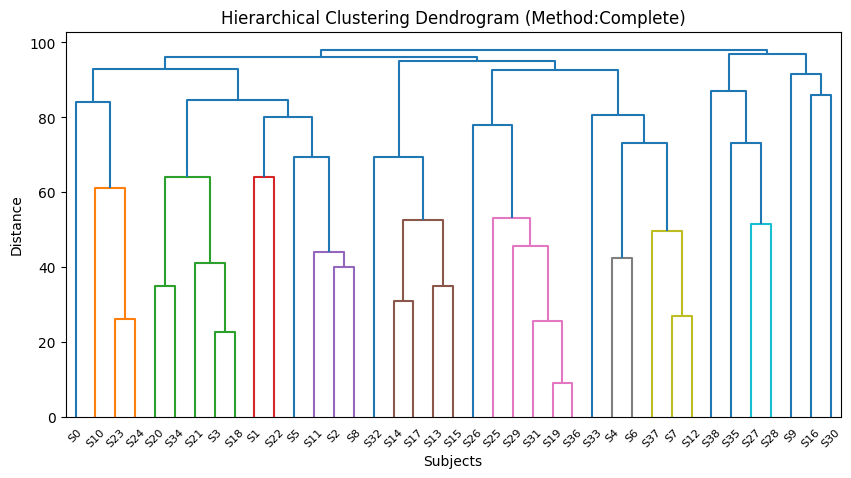

In [95]:
linksCmp = linkage(condensed, method ='complete')
plt.figure(figsize=(10,5))

dendrogram(linksCmp, labels=[f"S{i}" for i in range(Symetrized_Mat.shape[0])])
plt.title("Hierarchical Clustering Dendrogram (Method:Complete)")
plt.xlabel("Subjects")
plt.ylabel("Distance")
plt.show()

In [181]:
labelsCmp = fcluster(linksCmp, t = 95, criterion='distance')
groupsCmp = list(set(labelsCmp))
print("Unique Groups:",groupsCmp)
print("Cluster labels:", labelsCmp)

Unique Groups: [1, 2, 3, 4]
Cluster labels: [1 1 1 1 2 1 2 2 1 4 1 1 2 2 2 2 4 2 1 2 1 1 1 1 1 2 2 3 3 2 4 2 2 2 1 3 2
 2 3]


In [182]:
nSub = Symetrized_Mat.shape[0]
predictedClust = []

for thisSub in range(nSub):
    mask = np.arange(nSub) != thisSub
    trainMat = Symetrized_Mat[np.ix_(mask, mask)]
    
    linkageTrain = linkage(squareform(trainMat), method='complete')
    clusterTrain = fcluster(linkageTrain, t=95, criterion='distance')

    testDist = Symetrized_Mat[thisSub, mask] 
    
    clusterMeans = []
    for cluster in np.unique(clusterTrain):
        members = np.where(clusterTrain == cluster)[0]
        meanDist = np.mean(testDist[members])
        clusterMeans.append((cluster, meanDist))
    
    predictedClust.append(min(clusterMeans, key=lambda x: x[1])[0])
    
    print(f"Subject {thisSub} would be assigned to cluster {predictedClust[thisSub]}")

Subject 0 would be assigned to cluster 4
Subject 1 would be assigned to cluster 3
Subject 2 would be assigned to cluster 1
Subject 3 would be assigned to cluster 2
Subject 4 would be assigned to cluster 3
Subject 5 would be assigned to cluster 3
Subject 6 would be assigned to cluster 3
Subject 7 would be assigned to cluster 2
Subject 8 would be assigned to cluster 1
Subject 9 would be assigned to cluster 2
Subject 10 would be assigned to cluster 2
Subject 11 would be assigned to cluster 3
Subject 12 would be assigned to cluster 3
Subject 13 would be assigned to cluster 1
Subject 14 would be assigned to cluster 2
Subject 15 would be assigned to cluster 2
Subject 16 would be assigned to cluster 4
Subject 17 would be assigned to cluster 3
Subject 18 would be assigned to cluster 3
Subject 19 would be assigned to cluster 1
Subject 20 would be assigned to cluster 1
Subject 21 would be assigned to cluster 1
Subject 22 would be assigned to cluster 4
Subject 23 would be assigned to cluster 1
Su

In [183]:
sum(labelsCmp == predictedClust) / 39

0.38461538461538464

In [184]:
adjusted_rand_score(labelsCmp,predictedClust)

-0.004850571115631357

In [163]:
adjRand = []
for cutSpot in np.arange(1, 101):
    labelsCmpMany = fcluster(linksCmp, t = cutSpot, criterion='distance')
    if len(set(labelsCmp)) < 2:
        print(f"Warning: only {len(set(labelsCmp))} cluster(s) at t = {cutSpot}")

    nSub = Symetrized_Mat.shape[0]
    predictedClust = []

    for thisSub in range(nSub):
        mask = np.arange(nSub) != thisSub
        trainMat = Symetrized_Mat[np.ix_(mask, mask)]
    
        linkageTrain = linkage(squareform(trainMat), method='complete')
        clusterTrain = fcluster(linkageTrain, t=cutSpot, criterion='distance')
    
        testDist = Symetrized_Mat[thisSub, mask] 
    
        clusterMeans = []
        for cluster in np.unique(clusterTrain):
            members = np.where(clusterTrain == cluster)[0]
            meanDist = np.mean(testDist[members])
            clusterMeans.append((cluster, meanDist))
    
        predictedClust.append(min(clusterMeans, key=lambda x: x[1])[0])
    
    ari = adjusted_rand_score(labelsCmpMany,predictedClust)
    adjRand.append(ari)

In [185]:
trimmedAdjRand = adjRand[:-3]
print(max(trimmedAdjRand))
trimmedAdjRand.index(max(trimmedAdjRand))

0.22477806445970175


95

In [173]:
print(adjRand[:-3])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0026058631921824105, -0.0026058631921824105, -0.0026058631921824105, -0.002601998334721066, -0.002601998334721066, -0.002601998334721066, -0.002601998334721066, -0.002601998334721066, -0.002601998334721066, -0.002601998334721066, -0.002601998334721066, -0.002601998334721066, -0.002601998334721066, -0.0050233586175717085, -0.0050233586175717085, -0.0050233586175717085, -0.011294649159960469, -0.013232764324467381, -0.013232764324467381, -0.013232764324467381, -0.013232764324467381, -0.014541334214626316, -0.014541334214626316, -0.014541334214626316, -0.014541334214626316, -0.016281024642746538, -0.019325616507297434, -0.019325616507297434, -0.019583373332053376, -0.019583373332053376, -0.020995997637950264, -0.024715332332950833, -0.024715332332950833, -0.026657060518731988, -0.029166666666666667, -0.028346177695101425, 0.01575386896487814, 0.01575386896487814, 0.010399795413860711, 0.010399795413860711, 0.005422527649522173, 0.0054225276

Text(0, 0.5, 'Calculated Adjusted Random Score')

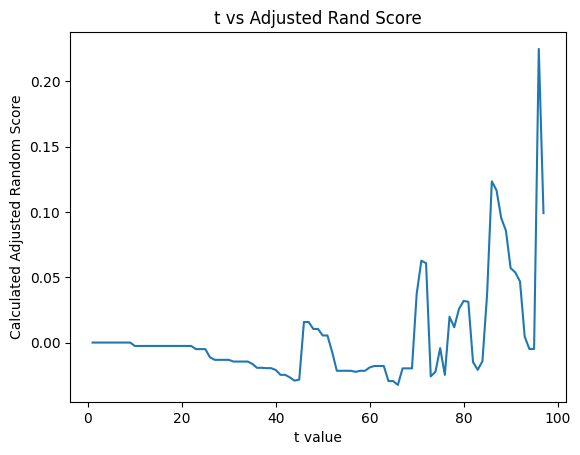

In [187]:
plt.plot(np.arange(1, 98),trimmedAdjRand)
plt.title("t vs Adjusted Rand Score")
plt.xlabel("t value")
plt.ylabel("Calculated Adjusted Random Score")

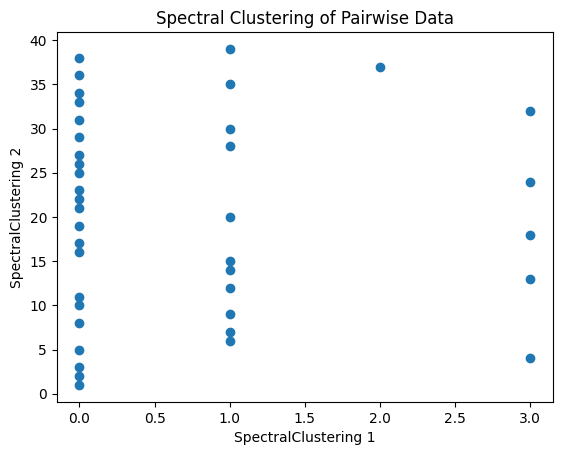

In [77]:
spectral = SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans')
sCloud = spectral.fit_predict(Symetrized_Mat)
plt.scatter(sCloud,range(1, 40))
plt.title("Spectral Clustering of Pairwise Data")
plt.xlabel("SpectralClustering 1")
plt.ylabel("SpectralClustering 2")
plt.show()

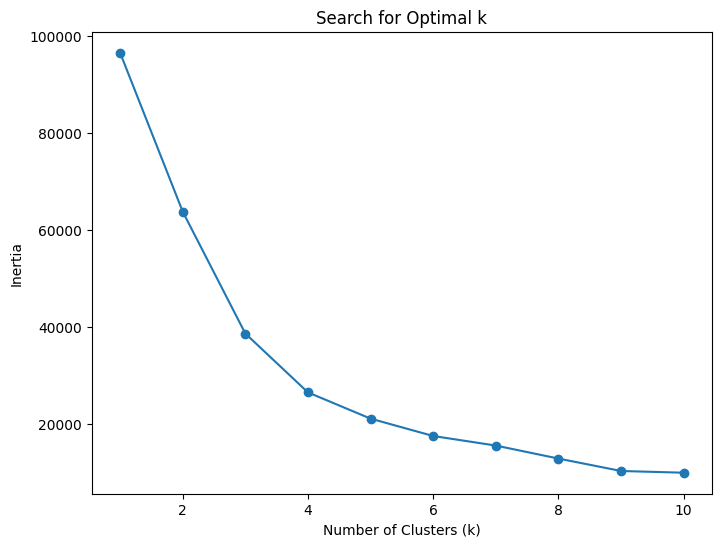

In [90]:
inertiaValues = []

for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k, random_state=67)
    kmeans.fit(embeddedPoints)
    inertiaValues.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertiaValues, marker='o')
plt.title('Search for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [88]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embeddedPoints = mds.fit_transform(Symetrized_Mat)

[1 3 2 2 1 2 2 2 2 3 0 2 1 3 3 3 1 3 1 1 1 2 2 0 0 1 0 0 0 1 3 1 2 1 1 0 1
 2 0]


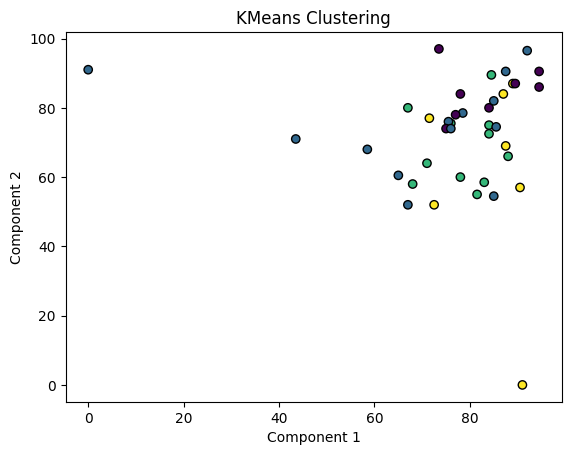

In [89]:
kMeans = KMeans(n_clusters=4, n_init='auto')
kcloud = kMeans.fit_predict(embeddedPoints)

print(kcloud)

plt.scatter(Symetrized_Mat[:, 0], Symetrized_Mat[:, 1], c=kcloud, cmap='viridis', edgecolors='k')
plt.title("KMeans Clustering")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()